## Machine Learning Project: Apartment Rent Price in NYC (Part 2)

This study is based on Terrence Parr and Jeremy Howard's ebook: <a href="https://mlbook.explained.ai/">The Mechanics of Machine Learning</a>

You will need to install the following packages:

- rfpimp              : pip install rfpimp
- category_encoders   : pip install category_encoders

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# importing the dataset
df = pd.read_csv("data/rent.csv", parse_dates=['created'])

# cleaning the data
df_clean = df[(df.price>1_000) & (df.price<10_000)]
df_clean = df_clean[(df_clean.longitude!=0) | (df_clean.latitude!=0)]
df_clean = df_clean[(df_clean['latitude']>40.55) &
                    (df_clean['latitude']<40.94) &
                    (df_clean['longitude']>-74.1) &
                    (df_clean['longitude']<-73.67)]
df = df_clean

In [3]:
# train the numeric features
from rfpimp import * 
from sklearn.ensemble import RandomForestRegressor

numfeatures = ['bathrooms', 'bedrooms', 'longitude', 'latitude']
X, y = df[numfeatures], df['price']
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X, y)
oob_baseline = rf.oob_score_
print(oob_baseline)

0.8678772188166795


In [4]:
# total number of nodes in all decision trees of the forest and the height (in nodes) of the typical tree
print(f"{rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height")

2,433,564 tree nodes and 35.0 median tree height


In [5]:
# get the baseline for feature importances
def showimp(rf, X, y):
    features = list(X.columns)
    features.remove('latitude')
    features.remove('longitude')
    features += [['latitude','longitude']]

    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')

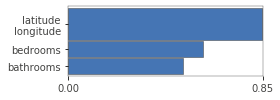

In [8]:
showimp(rf, X, y)

### Encoding Categorical Variables

In [6]:
# interest_level feature
print(df['interest_level'].value_counts())

low       33270
medium    11203
high       3827
Name: interest_level, dtype: int64


In [7]:
# converting ordinal variables from strings
df['interest_level'] = df['interest_level'].map({'low':1,'medium':2,'high':3})
print(df['interest_level'].value_counts())

1    33270
2    11203
3     3827
Name: interest_level, dtype: int64


In [8]:
# create function that will test the features
def test(X, y):
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 {oob:.5f} using {n:,d} tree nodes with {h} median tree height")
    return rf, oob

In [9]:
# train the model then evaluate : numeric features + categorical variable
X, y = df[['interest_level']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.87021 using 3,023,564 tree nodes with 36.0 median tree height


### Extracting Features from Strings

In [17]:
# normalize the string columns to be lowercase and convert any missing values
df['description'] = df['description'].fillna('')
df['description'] = df['description'].str.lower() # normalize to lower case
df['features'] = df['features'].fillna('') # fill missing w/blanks
df['features'] = df['features'].str.lower() # normalize to lower case

In [18]:
# has apartment been renovated?
df['renov'] = df['description'].str.contains("renov")

for w in ['doorman', 'parking', 'garage', 'laundry', 
          'Elevator', 'fitness center', 'dishwasher']:
    df[w] = df['features'].str.contains(w)
df[['doorman', 'parking', 'garage', 'laundry']].head(5)

,doorman,parking,garage,laundry
0,False,False,False,True
1,True,False,False,True
2,True,False,False,True
3,False,False,False,False
4,True,False,False,True


In [19]:
# count the number of strings
df["num_desc_words"] = df["description"].apply(lambda x: len(x.split()))
df["num_features"] = df["features"].apply(lambda x: len(x.split(",")))
df["num_photos"] = df["photos"].apply(lambda x: len(x.split(",")))

In [20]:
# check if the new features will affect the performance of the model
textfeatures = [
    'num_photos', 'num_desc_words', 'num_features',
    'doorman', 'parking', 'garage', 'laundry', 
    'Elevator', 'fitness center', 'dishwasher',
    'renov'
]
X, y = df[textfeatures+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.86261 using 4,771,434 tree nodes with 43.0 median tree height


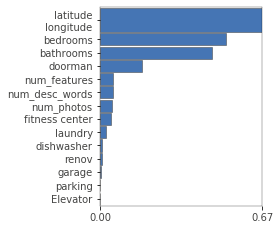

In [21]:
# accuracy does not improve with these features and that the complexity of the model is higher, 
#but this does provide useful marketing information
showimp(rf, X, y)

### Synthesizing Numeric Features

In [22]:
# check if there is predictive power in the ratio of bedrooms to bathroom
df["beds_to_baths"] = df["bedrooms"]/(df["bathrooms"]+1) # avoid div by 0
X, y = df[['beds_to_baths']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.86748 using 2,433,350 tree nodes with 35.0 median tree height


In [23]:
# combining a numeric column with the target, such as the ratio of bedrooms to price:
df["beds_per_price"] = df["bedrooms"] / df["price"]
X, y = df[['beds_per_price']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.98614 using 1,316,846 tree nodes with 31.0 median tree height


We have effectively copied the price column into the feature set, 
kind of like studying for a quiz by looking at the answers. 
This is a form of data leakage, which is a general term for the use of 
features that directly or indirectly hint at the target variable.

In [24]:
# To illustrate how this leakage causes overfitting, 
# let's split out 20% of the data as a validation set and compute the beds_per_price feature for the training set:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.20)
df_train = df_train.copy()
df_train['beds_per_price'] = df_train['bedrooms'] / df_train["price"]
df_train[['beds_per_price','bedrooms']].head(5)

,beds_per_price,bedrooms
37012,0.000000,0
49207,0.000000,0
22462,0.000606,2
48269,0.000546,3
5117,0.000000,0


Once we have the beds_per_price feature for the training set, we can compute a dictionary mapping bedrooms to the beds_per_price feature. Then, we can synthesize the beds_per_price in the validation set using map() on the bedrooms column:

In [25]:
bpmap = dict(zip(df_train["bedrooms"],df_train["beds_per_price"]))
df_test = df_test.copy()
df_test["beds_per_price"] = df_test["bedrooms"].map(bpmap)
avg = np.mean(df_test['beds_per_price'])
df_test['beds_per_price'].fillna(avg, inplace=True)
print(df_test['beds_per_price'].head(5))

33267    0.001143
33886    0.000351
1299     0.000000
42103    0.000000
29720    0.000667
Name: beds_per_price, dtype: float64


In [26]:
# train an RF model using just the training set and evaluate its performance using just the validation set:
X_train, y_train = df_train[['beds_per_price']+numfeatures], df_train['price']
X_test, y_test = df_test[['beds_per_price']+numfeatures], df_test['price']

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
oob_overfit = rf.score(X_test, y_test) # don't test training set
print(f"OOB R^2 {oob_overfit:.5f}")
print(f"{rfnnodes(rf):,d} nodes, {np.median(rfmaxdepths(rf))} median height")

OOB R^2 -0.24689
1,163,804 nodes, 30.0 median height


### Target encoding categorical variables

In [27]:
# The average rent price per building can be obtained by grouping the data by building_id and asking for the mean:
df.groupby('building_id').mean()[['price']].head(5)

,price
building_id,
0,3195.9321
00005cb939f9986300d987652c933e15,3399.0000
00024d77a43f0606f926e2312513845c,2000.0000
000ae4b7db298401cdae2b0ba1ea8146,2400.0000
0012f1955391bca600ec301035b97b65,3700.0000


In [30]:
# To prevent overfitting, the idea is to compute the mean from a subset of the training data targets for each category.
# Here's how to use the TargetEncoder object to encode three categorical variables from the data set and get an OOB score:
from category_encoders.target_encoder import TargetEncoder
df = df.reset_index() # not sure why TargetEncoder needs this but it does
targetfeatures = ['building_id']
encoder = TargetEncoder(cols=targetfeatures)
encoder.fit(df, df['price'])
df_encoded = encoder.transform(df, df['price'])

X, y = df_encoded[targetfeatures+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.87273 using 2,746,908 tree nodes with 39.0 median tree height


In [31]:
# to test the model with a validation set. Let's split out 20% as a validation set and get a baseline for numeric features:
df_train, df_test = train_test_split(df, test_size=0.20)

# TargetEncoder needs the resets, not sure why
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

X_train = df_train[numfeatures]
y_train = df_train['price']
X_test = df_test[numfeatures]
y_test = df_test['price']

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
s_validation = rf.score(X_test, y_test)
print(f"{s_validation:4f} score {rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height")

0.862590 score 2,128,798 tree nodes and 35.0 median tree height


In [32]:
# With that baseline, let's see what happens when we properly target encode the validation set, 
# that is, using only data from the training set (warning: this takes several minutes to execute):
enc = TargetEncoder(cols=targetfeatures)
enc.fit(df_train, df_train['price'])
df_train_encoded = enc.transform(df_train, df_train['price'])
df_test_encoded = enc.transform(df_test)

X_train = df_train_encoded[targetfeatures+numfeatures]
y_train = df_train_encoded['price']
X_test = df_test_encoded[targetfeatures+numfeatures]
y_test = df_test_encoded['price']

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
s_tenc_validation = rf.score(X_test, y_test)
print(f"{s_tenc_validation:.4f} score {rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height")

0.8541 score 2,383,930 tree nodes and 38.0 median tree height


### Injecting external neighborhood info
Forbes magazine has an article, The Top 10 New York City Neighborhoods to Live In, According to the Locals, from which we can get neighborhood names. Then, using a mapping website, we can estimate the longitude and latitude of those neighborhoods and record them like this:

In [33]:
hoods = {
    "hells" : [40.7622, -73.9924],
    "astoria" : [40.7796684, -73.9215888],
    "Evillage" : [40.723163774, -73.984829394],
    "Wvillage" : [40.73578, -74.00357],
    "LowerEast" : [40.715033, -73.9842724],
    "UpperEast" : [40.768163594, -73.959329496],
    "ParkSlope" : [40.672404, -73.977063],
    "Prospect Park" : [40.93704, -74.17431],
    "Crown Heights" : [40.657830702, -73.940162906],
    "financial" : [40.703830518, -74.005666644],
    "brooklynheights" : [40.7022621909, -73.9871760513],
    "gowanus" : [40.673, -73.997]
}

In [34]:
# To synthesize new features, we compute the so-called Manhattan distance (also called L1 distance)
# from each apartment to each neighborhood center
for hood,loc in hoods.items():
    # compute manhattan distance
    df[hood] = np.abs(df.latitude - loc[0]) + np.abs(df.longitude - loc[1])

In [35]:
# train again the model:
hoodfeatures = list(hoods.keys())
X, y = df[numfeatures+hoodfeatures], df['price']
rf, oob_hood = test(X, y)

OOB R^2 0.87268 using 2,411,936 tree nodes with 43.0 median tree height


In [36]:
# The new proximity features effectively triangulate an apartment relative to desirable neighborhoods, 
# which means we probably don't need apartment longitude and latitude anymore. 
# Dropping longitude and latitude and retraining a model shows a similar OOB score and shallower trees:
X = X.drop(['longitude','latitude'],axis=1)
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X, y)
print(f"{rf.oob_score_:.4f} score {rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height")

0.8700 score 2,421,922 tree nodes and 40.0 median tree height


In [37]:
# FINAL MODEL: combining all the feature engineering techniques for categorical variables to numeric features
X = df[['interest_level']+textfeatures+hoodfeatures+numfeatures]
rf, oob_combined = test(X, y)

OOB R^2 0.87931 using 4,839,556 tree nodes with 44.0 median tree height
